In [53]:
import mediapipe as mp
import cv2
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [54]:
class KeypointDataset(Dataset):
    def __init__(self, csv_file):
        self.data = pd.read_csv(csv_file)
        self.X = self.data.drop(columns=['label']).values.astype(np.float32)
        self.y = self.data['label'].values.astype(np.int64)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        X = torch.tensor(self.X[idx])
        y = torch.tensor(self.y[idx])
        return X, y

In [55]:
dataset = KeypointDataset('keypoints_dataset.csv')

In [56]:
print(type(dataset[10]))
print(len(dataset))

<class 'tuple'>
136


In [57]:
img, label = dataset[10]
print(type(img), type(label))
print(img.shape)
print(img.dtype)
print(img.max(), img.min())
print(label)
print(img.squeeze().shape)

<class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([99])
torch.float32
tensor(1.1827) tensor(-0.4215)
tensor(0)
torch.Size([99])


In [ ]:
# 하이퍼파라미퍼 튜님

batch_size = 64
learning_rate = 0.0001
num_epochs = 2000
dropout_n = 0.3

In [ ]:
class KeypointClassifier(nn.Module):
    def __init__(self, input_size=99, hidden_size=128, num_classes=2):
        super(KeypointClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, num_classes)
        self.dropout = nn.Dropout(dropout_n)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [60]:
# Load dataset

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

dataloader_train = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dataloader_val = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
model = KeypointClassifier()
ce = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)


for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for images, labels in dataloader_train:
        optimizer.zero_grad()
        # scheduler.step()
        logits = model(images)
        loss = ce(logits, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"epoch {epoch+1}/{num_epochs}, Loss: {total_loss:.4f}")

epoch 1/3000, Loss: 1.4074
epoch 2/3000, Loss: 1.3935
epoch 3/3000, Loss: 1.3923
epoch 4/3000, Loss: 1.3816
epoch 5/3000, Loss: 1.3771
epoch 6/3000, Loss: 1.3728
epoch 7/3000, Loss: 1.3796
epoch 8/3000, Loss: 1.3621
epoch 9/3000, Loss: 1.3732
epoch 10/3000, Loss: 1.3656
epoch 11/3000, Loss: 1.3394
epoch 12/3000, Loss: 1.3535
epoch 13/3000, Loss: 1.3263
epoch 14/3000, Loss: 1.3663
epoch 15/3000, Loss: 1.3495
epoch 16/3000, Loss: 1.3322
epoch 17/3000, Loss: 1.3060
epoch 18/3000, Loss: 1.3177
epoch 19/3000, Loss: 1.3480
epoch 20/3000, Loss: 1.3290
epoch 21/3000, Loss: 1.3260
epoch 22/3000, Loss: 1.3271
epoch 23/3000, Loss: 1.2951
epoch 24/3000, Loss: 1.3142
epoch 25/3000, Loss: 1.2959
epoch 26/3000, Loss: 1.2532
epoch 27/3000, Loss: 1.2311
epoch 28/3000, Loss: 1.2898
epoch 29/3000, Loss: 1.2104
epoch 30/3000, Loss: 1.2760
epoch 31/3000, Loss: 1.2387
epoch 32/3000, Loss: 1.2375
epoch 33/3000, Loss: 1.2414
epoch 34/3000, Loss: 1.2063
epoch 35/3000, Loss: 1.2205
epoch 36/3000, Loss: 1.1843
e

In [62]:
@torch.no_grad()
def validate(f, dataloader):
    num_correct = 0
    num_total = 0
    for images, labels in dataloader:
        # images = images.to(device)
        # labels = labels.to(device)
        logits = f(images)
        prediction = logits.argmax(dim=1)
        num_correct += (prediction == labels).type(torch.float).sum().item()
        num_total += len(labels)
    return num_correct / num_total

Epoch 1/3000, Loss: 1.3892
Epoch 2/3000, Loss: 1.4013
Epoch 3/3000, Loss: 1.3951
Epoch 4/3000, Loss: 1.3696
Epoch 5/3000, Loss: 1.3921
Epoch 6/3000, Loss: 1.3820
Epoch 7/3000, Loss: 1.3984


Epoch 8/3000, Loss: 1.3906
Epoch 9/3000, Loss: 1.3922
Epoch 10/3000, Loss: 1.3980
Epoch 11/3000, Loss: 1.3853
Epoch 12/3000, Loss: 1.3779
Epoch 13/3000, Loss: 1.3826
Epoch 14/3000, Loss: 1.3830
Epoch 15/3000, Loss: 1.3745
Epoch 16/3000, Loss: 1.3785
Epoch 17/3000, Loss: 1.3804
Epoch 18/3000, Loss: 1.3885
Epoch 19/3000, Loss: 1.3882
Epoch 20/3000, Loss: 1.3813
Epoch 21/3000, Loss: 1.3868
Epoch 22/3000, Loss: 1.3976
Epoch 23/3000, Loss: 1.3634
Epoch 24/3000, Loss: 1.3632
Epoch 25/3000, Loss: 1.3702
Epoch 26/3000, Loss: 1.3678
Epoch 27/3000, Loss: 1.3564
Epoch 28/3000, Loss: 1.3776
Epoch 29/3000, Loss: 1.3693
Epoch 30/3000, Loss: 1.3883
Epoch 31/3000, Loss: 1.3787
Epoch 32/3000, Loss: 1.3825
Epoch 33/3000, Loss: 1.3799
Epoch 34/3000, Loss: 1.3792
Epoch 35/3000, Loss: 1.3741
Epoch 36/3000, Loss: 1.3759
Epoch 37/3000, Loss: 1.3714
Epoch 38/3000, Loss: 1.3549
Epoch 39/3000, Loss: 1.3693
Epoch 40/3000, Loss: 1.3775
Epoch 41/3000, Loss: 1.3796
Epoch 42/3000, Loss: 1.3675
Epoch 43/3000, Loss: 1

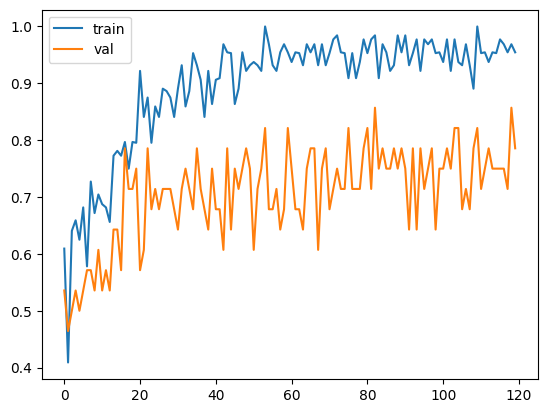

In [63]:
model = KeypointClassifier()
ce = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

accuracies_train = []
accuracies_val = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for images, labels in dataloader_train:
        optimizer.zero_grad()
        logits = model(images)
        loss = ce(logits, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        # 50 epoch 마다 계산
        if epoch % 50 == 0:
            prediction = logits.argmax(dim=1)
            num_correct = (prediction == labels).type(torch.float).sum().item()
            accuracy_train = num_correct / len(labels)
            accuracies_train.append(accuracy_train)
            accuracy_val = validate(model, dataloader_val)
            accuracies_val.append(accuracy_val)

    # Print loss at the end of each epoch
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss:.4f}")

# Plot training and validation accuracies
plt.plot(accuracies_train, label="train")
plt.plot(accuracies_val, label="val")
plt.legend()
plt.show()

In [64]:
print(accuracies_train)
print(accuracies_val)

[0.609375, 0.4090909090909091, 0.640625, 0.6590909090909091, 0.625, 0.6818181818181818, 0.578125, 0.7272727272727273, 0.671875, 0.7045454545454546, 0.6875, 0.6818181818181818, 0.65625, 0.7727272727272727, 0.78125, 0.7727272727272727, 0.796875, 0.75, 0.796875, 0.7954545454545454, 0.921875, 0.8409090909090909, 0.875, 0.7954545454545454, 0.859375, 0.8409090909090909, 0.890625, 0.8863636363636364, 0.875, 0.8409090909090909, 0.890625, 0.9318181818181818, 0.859375, 0.8863636363636364, 0.953125, 0.9318181818181818, 0.90625, 0.8409090909090909, 0.921875, 0.8636363636363636, 0.90625, 0.9090909090909091, 0.96875, 0.9545454545454546, 0.953125, 0.8636363636363636, 0.890625, 0.9545454545454546, 0.921875, 0.9318181818181818, 0.9375, 0.9318181818181818, 0.921875, 1.0, 0.96875, 0.9318181818181818, 0.921875, 0.9545454545454546, 0.96875, 0.9545454545454546, 0.9375, 0.9545454545454546, 0.953125, 0.9318181818181818, 0.96875, 0.9545454545454546, 0.96875, 0.9318181818181818, 0.96875, 0.9318181818181818, 0.9

In [65]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for X, y in dataloader_val:
        outputs = model(X)
        _, predicted = torch.max(outputs, 1)
        total += y.size(0)
        correct += (predicted == y).sum().item()

accuracy = correct / total
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.79


Incorrect



I0000 00:00:1733903452.781527  811320 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 88.1), renderer: Apple M2 Pro
W0000 00:00:1733903452.847528  814397 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733903452.858609  814400 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


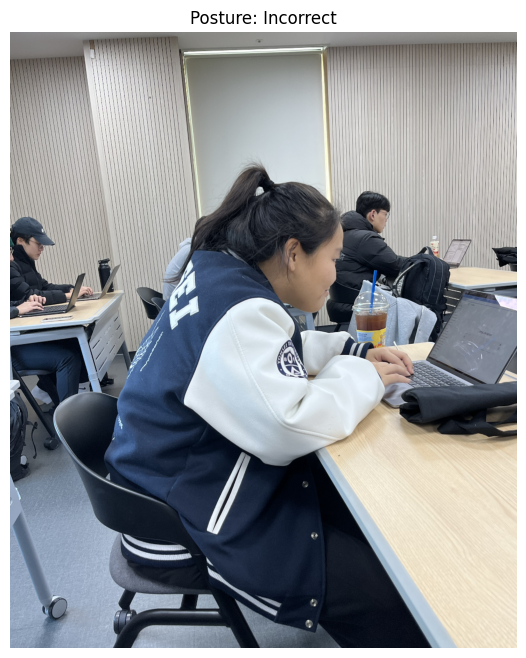

In [66]:
from PIL import Image

mp_pose = mp.solutions.pose

def extract_keypoints(image_path):
    # Initialize MediaPipe pose detection
    with mp_pose.Pose(static_image_mode=True) as pose:
        # Read and preprocess image
        image = cv2.imread(image_path)
        rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Process the image to detect keypoints
        results = pose.process(rgb_image)

        # Extract keypoints
        if results.pose_landmarks:
            keypoints = [(lm.x, lm.y, lm.z) for lm in results.pose_landmarks.landmark]
            return np.array(keypoints).flatten()  # Flatten to a single array
        else:
            return np.zeros(99)  # Return zeros if no keypoints detected

# Load a new image
new_image_path = 'incorrect_mimi.png'
keypoints = extract_keypoints(new_image_path)
keypoints_tensor = torch.tensor(keypoints, dtype=torch.float32).unsqueeze(0)

# Predict posture
model.eval()
with torch.no_grad():
    output = model(keypoints_tensor)
    _, predicted = torch.max(output, 1)
    posture = "Correct" if predicted[0] == 1 else "Incorrect"
    print(posture)
    print()

image = Image.open(new_image_path)

plt.figure(figsize=(8, 8))
plt.imshow(image)
plt.title(f"Posture: {posture}")
plt.axis('off')
plt.show()